🐙

Tacotron: Towards End-to-End Speech Synthesis: https://arxiv.org/abs/1703.10135

In [1]:
# Choose your favorite model
checkpoint_path = "../checkpoints/checkpoint_step880000.pth"

In [2]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

# Use text & audio modules from existing Tacotron implementation.
import sys
sys.path.append("../lib/tacotron")
from text import text_to_sequence, symbols
from util import audio

Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch
from torch.autograd import Variable
import numpy as np

from tacotron_pytorch import Tacotron
from hparams import hparams

import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio

In [4]:
use_cuda = torch.cuda.is_available()
fs = 20000
hop_length = 250

In [5]:
def visualize(alignment, spectrogram):
    figure(figsize=(16,16))
    
    subplot(2,1,1)
    imshow(alignment.T, aspect="auto", origin="lower", interpolation=None)
    xlabel("Decoder timestamp")
    ylabel("Encoder timestamp")
    colorbar()

    subplot(2,1,2)
    librosa.display.specshow(spectrogram.T, sr=fs, 
                             hop_length=hop_length, x_axis="time", y_axis="linear")
    colorbar()

In [6]:
def tts(model, text):
    if use_cuda:
        model = model.cuda()
    # TODO: Turning off dropout of decoder's prenet causes serious performance
    # regression, not sure why.
    # model.decoder.eval()
    model.encoder.eval()
    model.postnet.eval()

    sequence = np.array(text_to_sequence(text, ["english_cleaners"]))
    sequence = Variable(torch.from_numpy(sequence)).unsqueeze(0)
    if use_cuda:
        sequence = sequence.cuda()

    # Greedy decoding
    mel_outputs, linear_outputs, alignments = model(sequence)

    linear_output = linear_outputs[0].cpu().data.numpy()
    spectrogram = audio._denormalize(linear_output)
    alignment = alignments[0].cpu().data.numpy()

    # Predicted audio signal
    waveform = audio.inv_spectrogram(linear_output.T)
    
    return waveform, alignment, spectrogram

In [7]:
def test_one_text(model, text, figures=True):
    waveform, alignment, spectrogram = tts(model, text)
    if figures:
        visualize(alignment, spectrogram)
    IPython.display.display(Audio(waveform, rate=fs))

## Model

In [8]:
model = Tacotron(n_vocab=len(symbols))

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["state_dict"])

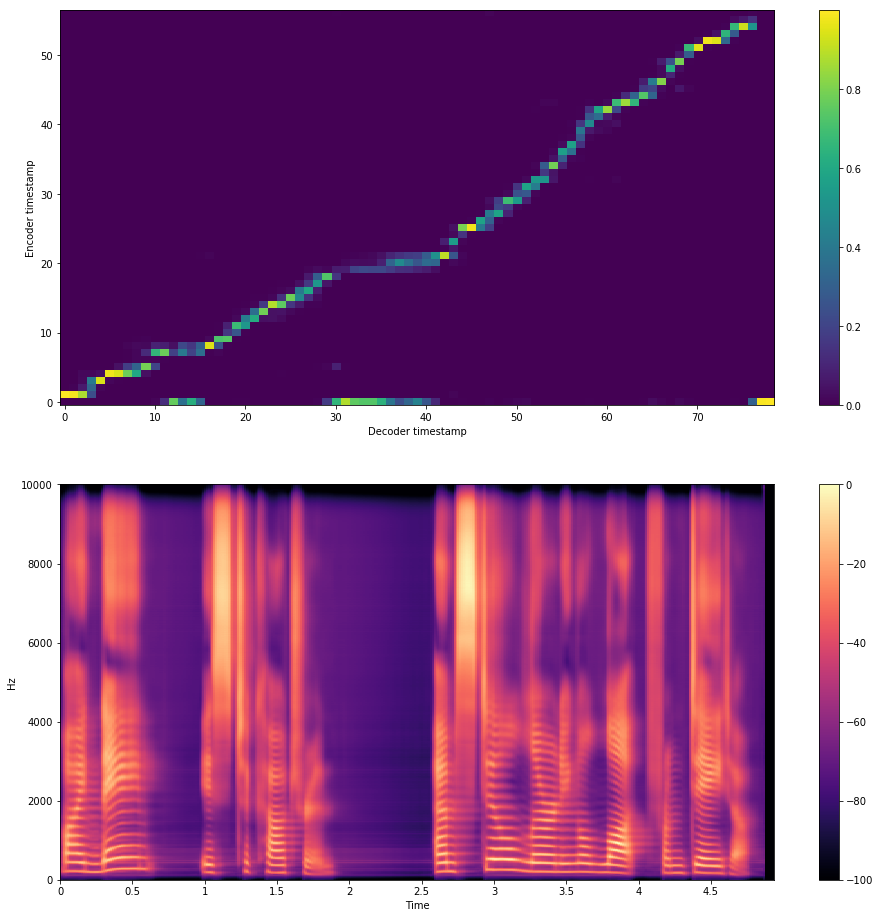

In [9]:
test_one_text(model, "My name is Tacotron. I'm still learning a lot from data.")

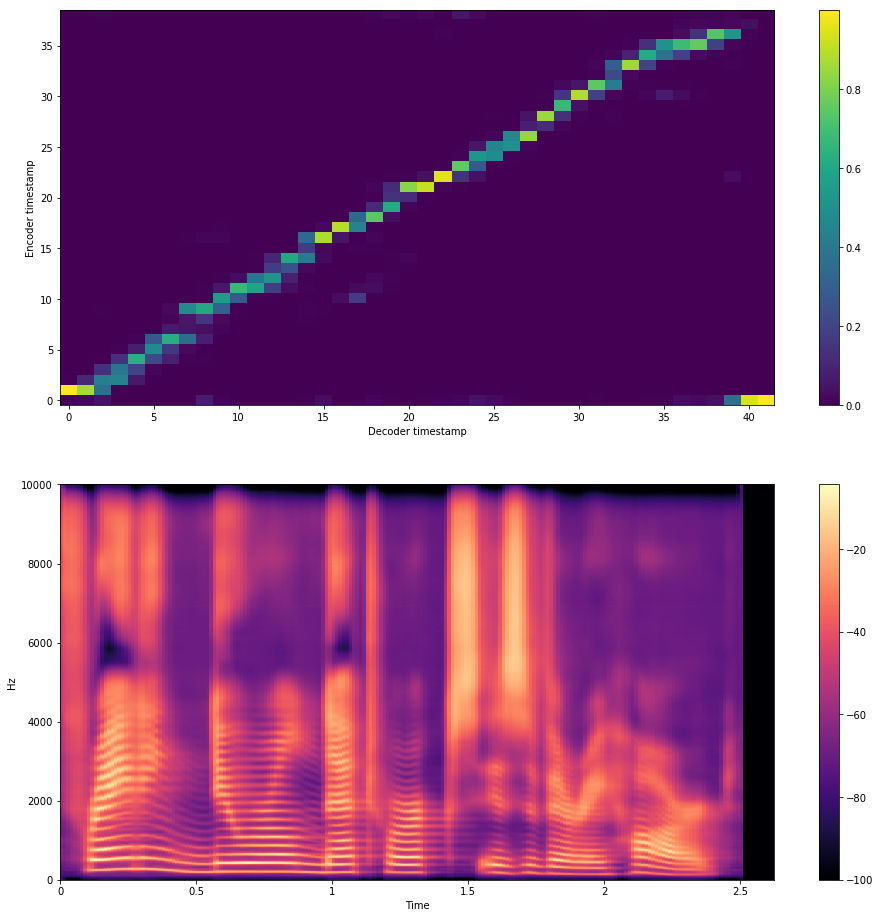

In [10]:
test_one_text(model, "Training neural networks is very hard!")

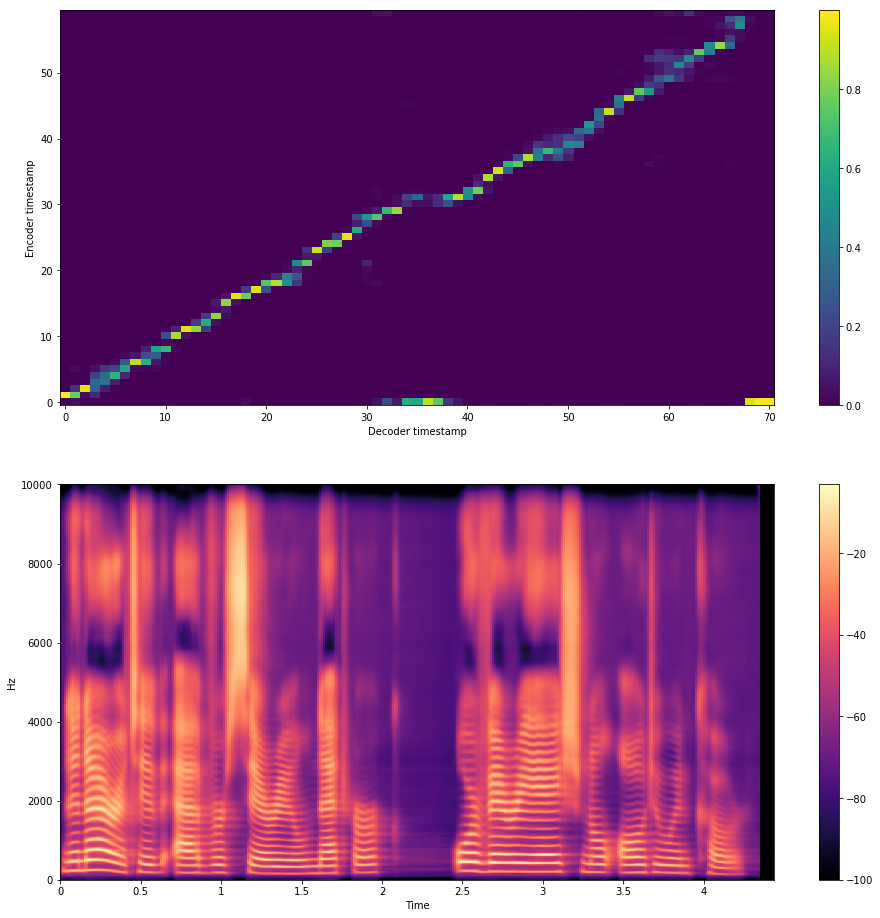

In [11]:
test_one_text(model, "Generative adversarial network or variational auto-encoder.")

In [12]:
texts = [
    "Scientists at the CERN laboratory say they have discovered a new particle.",
    "There's a way to measure the acute emotional intelligence that has never gone out of style.",
    "President Trump met with other leaders at the Group of 20 conference.",
    "The Senate's bill to repeal and replace the Affordable Care Act is now imperiled.",
    "Generative adversarial network or variational auto-encoder.",
    "The buses aren't the problem, they actually provide a solution.",
]

for idx, text in enumerate(texts):
    print(idx, text)
    test_one_text(model, text, figures=False)

0 Scientists at the CERN laboratory say they have discovered a new particle.


1 There's a way to measure the acute emotional intelligence that has never gone out of style.


2 President Trump met with other leaders at the Group of 20 conference.


3 The Senate's bill to repeal and replace the Affordable Care Act is now imperiled.


4 Generative adversarial network or variational auto-encoder.


5 The buses aren't the problem, they actually provide a solution.


## Try long sentences

158


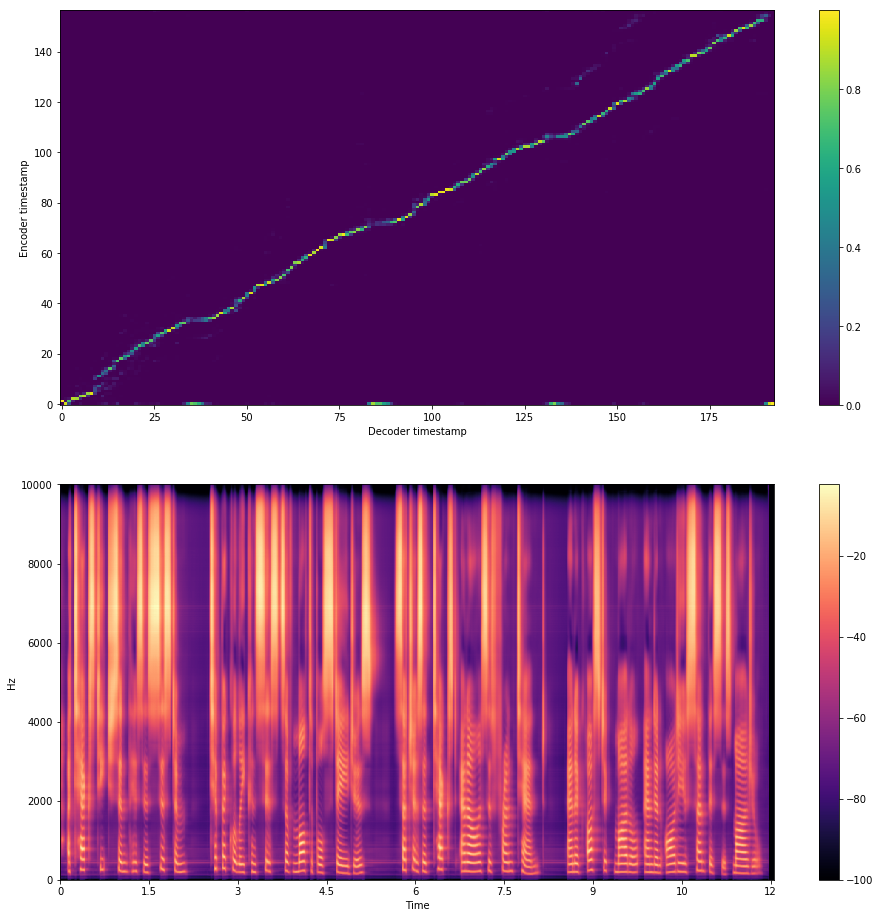

In [13]:
text = """A text-to-speech synthesis system typically consists of multiple stages, 
such as a text analysis frontend, an acoustic model and an audio synthesis module. 
"""
print(len(text))
model.decoder.max_decoder_steps = 500
test_one_text(model, text)

266


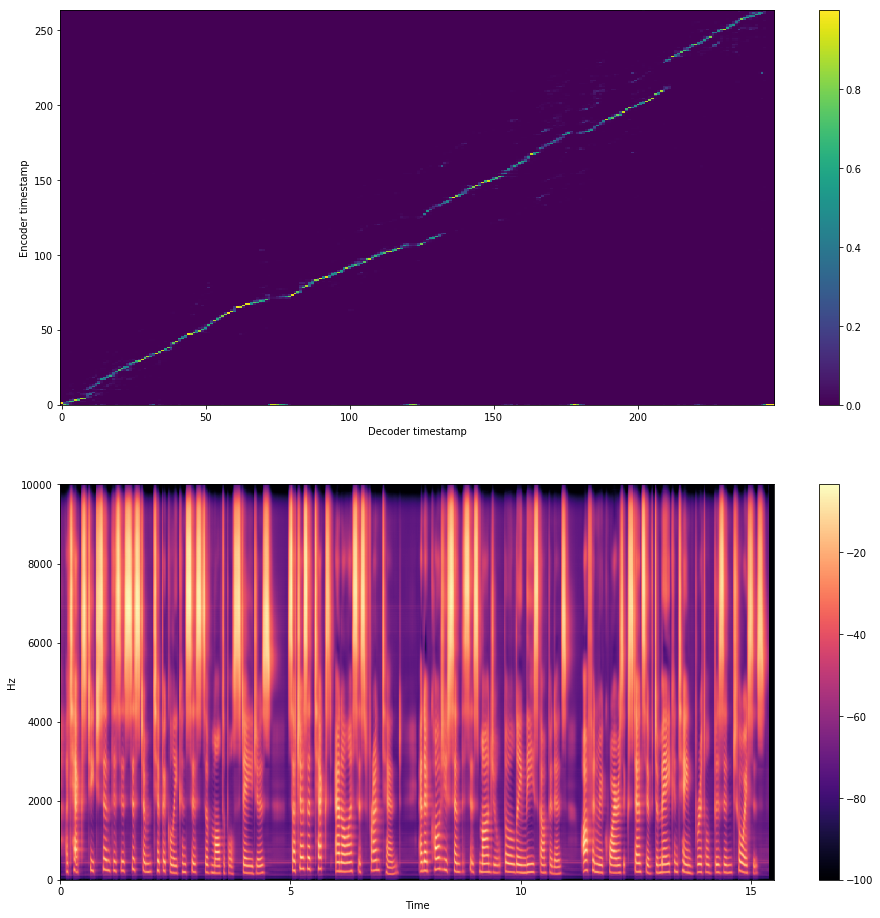

In [14]:
text = """A text-to-speech synthesis system typically consists of multiple stages, 
such as a text analysis frontend, an acoustic model and an audio synthesis module. 
Building these components often requires extensive domain expertise and may 
contain brittle design choices."""
print(len(text))
model.decoder.max_decoder_steps = 500
test_one_text(model, text)